[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shaivimalik/medicine_preprocessing-on-entire-dataset/blob/main/notebooks/03.ipynb)

# Introduction

In this notebook, we will continue our quest to understand data leakage
and its consequences. As in the previous notebook, we will explore a
specific type of data leakage: **preprocessing on training and test
set**. To demonstrate the impact of data leakage, we will create a
**Synthetic Dataset for classification** and train a **Support Vector
Machine (SVM) classifier with an RBF kernel** to determine the class.

We will experiment with two modeling approaches:

-   **Oversampling the entire dataset followed by splitting**: This
    approach may introduce data leakage due to potential information
    overlap between training and test sets after oversampling.

-   **Splitting the dataset before oversampling**: This approach may
    help mitigate data leakage by ensuring distinct training and test
    sets.

By comparing the performance of these models, we will examine the impact
of data leakage on model accuracy and generalisation.

Overview of the sections:

-   [Create the dataset](#create-the-dataset): We create a synthetic
    dataset using `scikit-learn`.

-   [SMOTE](#smote): We will implement the SMOTE oversampling technique.

-   [Training SVM - with Data
    Leakage](#training-svm---with-data-leakage): We will oversample the
    entire dataset before splitting it into training and test sets, and
    then train the SVM model.

-   [Training SVM - without Data
    Leakage](#training-svm---without-data-leakage): We will split the
    dataset into training and test sets, then oversample the training
    set before training the SVM model.

-   [Discussion](#discussion): We will evaluate the performance of
    models and discuss the importance of correct preprocessing.

# Create the dataset 📊

In this section, we will create the dataset using `make_classification`
from `scikit-learn` library. The dataset will consist of two-dimensional
feature vectors and binary targets. The dataset will be created with an
class imbalance, where the ratio between the majority and minority
classes will be 4:1.

We start by importing the required libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score

In [ ]:
X,y = make_classification(n_samples=45, n_features=2, n_redundant=0, random_state=5, weights=[0.8,0.2])

Next, we display the first 5 feature vectors and target values. We also
display the number of instances of both classes in our dataset.

In [ ]:
# Display the first 5 rows of the feature matrix X
X[:5]

In [ ]:
# Display the first 5 labels of the target vector y
y[:5]

In [ ]:
# Count the number of occurrences of each unique value in the array y
counts = np.unique(y,return_counts=True)
# Print the count of the first unique value
print("Count of",counts[0][0],":",counts[1][0])
# Print the count of the second unique value
print("Count of",counts[0][1],":",counts[1][1])

This code cell creates a scatter plot where the data points with a label
of 0.0 are colored green, and the data points with a label of 1.0 are
colored red. The x-axis represents the first feature, and the y-axis
represents the second feature.

In [ ]:
# Scatter plot of the dataset
plt.scatter(X[:,0],X[:,1], c=["tab:green" if i==0.0 else "tab:red" for i in y])
# Setting the label for the x-axis
plt.xlabel("Feature-1") 
# Setting the label for the y-axis
plt.ylabel("Feature-2") 
# Setting the limits for the x-axis
plt.xlim(-3, 3) 
# Setting the limits for the y-axis
plt.ylim(-3.5, 3.5) 
# Setting the title of the plot
plt.title("Dataset")
# Displaying the plot
plt.show() 

# SMOTE

**Synthetic Minority Over-sampling Technique (SMOTE)** is an
oversampling technique in which the minority class is oversampled by
creating synthetic samples[1]. The synthetic samples are generated with
the help of k minority class nearest neighbors. The algorithm generates
synthetic samples using the following steps:

-   For each minority class sample perform the steps N times, where N is
    the desired oversampling ratio:

    -   Identify its k-nearest neighbors (typically k=5) within the
        minority class.

    -   Randomly select one of these neighbors.

    -   Take the difference between the sample and its random nerest
        neighbor

    -   Multiply the difference by a random number between 0 and 1

    -   Add the resultant to the minority class sample to create the
        synthetic sample

> *Suppose N = 3 (meaning we’ll create three synthetic samples for each
> original minority sample)*
>
> *Minority Class Sample: \[9, 4, 11\]*
>
> *4 Minority Class Nearest Neighbors: \[11, 2, 13\], \[10, 5, 12\],
> \[8, 3, 11\], \[12, 3, 13\]*
>
> *Synthetic Sample 1:*
>
> *\[9, 4, 11\] + 0.47 * (\[10, 5, 12\] - \[9, 4, 11\])\*
>
> *= \[9, 4, 11\] + 0.47 * \[1, 1, 1\]\*
>
> *= \[9, 4, 11\] + \[0.47, 0.47, 0.47\]*
>
> *= \[9.47, 4.47, 11.47\]*
>
> *Synthetic Sample 2:*
>
> *\[9, 4, 11\] + 0.91 * (\[11, 2, 13\] - \[9, 4, 11\])\*
>
> *= \[9, 4, 11\] + 0.91 * \[2, -2, 2\]\*
>
> *= \[9, 4, 11\] + \[1.82, -1.82, 1.82\]*
>
> *= \[10.82, 2.18, 12.82\]*
>
> *Synthetic Sample 3:*
>
> *\[9, 4, 11\] + 0.68 * (\[8, 3, 11\] - \[9, 4, 11\])\*
>
> *= \[9, 4, 11\] + 0.68 * \[-1, -1, 0\]\*
>
> *= \[9, 4, 11\] + \[-0.68, -0.68, 0\]*
>
> *= \[8.32, 3.32, 11\]*

The above example in the form of Python code:

[1] Chawla, N.V., Bowyer, K.W., Hall, L.O. and Kegelmeyer, W.P., 2002.
SMOTE: synthetic minority over-sampling technique. Journal of artificial
intelligence research, 16, pp.321-357.

In [ ]:
# Number of synthetic samples to generate per minority sample
N = 3

minority_sample = np.array([9, 4, 11])

# K-nearest neighbors of the minority sample
knn = np.array([[11, 2, 13], [10, 5, 12], [8, 3, 11], [12, 3, 13]])

# List to store synthetic samples
syn_samples = []

for i in range(N):
    # Randomly select one of the k-nearest neighbors
    random_neighbor = knn[np.random.randint(0, knn.shape[0])]
    
    # Calculate the difference between the neighbor and the minority sample
    difference = random_neighbor - minority_sample
    
    # Create synthetic sample
    syn_sample = minority_sample + np.random.random() * difference
    
    print(f"Synthetic Sample {i+1}: {syn_sample}")
    
    # Add the synthetic sample to list
    syn_samples.append(syn_sample)

syn_samples = np.array(syn_samples)

In this way, SMOTE generates synthetic samples by utilizing minority
class samples and their k nearest neighbors. The number of synthetic
samples created from each minority sample is determined by the
oversampling ratio (N).

Given below is an implementation of SMOTE using NumPy and scikit-learn.
We calculate the value of N based on the imbalance present in the input
vectors. We generate the synthetic samples with the help of the populate
function present inside the sample method.

In [ ]:
class smote(object):
  """
  This class implements the SMOTE (Synthetic Minority Oversampling Technique) algorithm
  for oversampling imbalanced datasets.
  """
  def __init__(self, n_neighbors=5, N=None):

    np.random.seed(20)
    self.k = n_neighbors
    # Initialize the NearestNeighbors object with Euclidean distance
    self.nn = NearestNeighbors(n_neighbors=self.k + 1, metric='euclidean')
    self.N=N

  def sample(self, X, y):

    # Check if X and y are numpy arrays
    if not isinstance(X, np.ndarray):
      raise TypeError("X must be a numpy array, got", type(X).__name__,"instead")

    if not isinstance(y, np.ndarray):
      raise TypeError("X must be a numpy array, got", type(X).__name__,"instead")

    def populate(self, N, i, nnarray):

      nonlocal X
      nonlocal synthetic
      nonlocal new_index
      nonlocal parent
      nonlocal minority_X
      while N!=0:
        nn = np.random.randint(1,self.k+1)
        dif = minority_X[nnarray[:,nn]]-X[i]
        gap = np.random.random()
        synthetic[new_index] = X[i] + gap * dif
        parent.append([i,minority_idx[nnarray[:,nn]][0]])
        new_index += 1
        N -= 1

    # Identify unique classes and their counts
    unique_classes, class_counts = np.unique(y, return_counts=True)

    # Determine the minority and majority classes
    minority_class = unique_classes[np.argmin(class_counts)]
    majority_class = unique_classes[np.argmax(class_counts)]

    # Get indices of minority and majority class samples
    majority_idx = np.nonzero(y == majority_class)[0]
    minority_idx = np.nonzero(y == minority_class)[0]

    # Count of samples in each class
    ms = minority_idx.shape[0]
    ml = majority_idx.shape[0]

    print("\nSamples of minority class:",ms)
    print("Samples of majority class:", ml)

    # Calculate the number of synthetic samples needed
    if self.N is None: self.N = (ml -ms)//ms
    print("Number of synthetic samples to be generated:", self.N*ms,"\n")

    # Initialize the array to hold synthetic samples
    synthetic = np.zeros((self.N*ms, X.shape[1]))

    new_index = 0

    parent=[[i,i] for i in range(X.shape[0])]

    minority_X = X[minority_idx]

    # Fit the nearest neighbors model to the minority class data
    self.nn.fit(minority_X)

    # Generate synthetic samples for each minority class instance
    for i in minority_idx:
      nnarray = self.nn.kneighbors([X[i]], return_distance=False)
      populate(self, self.N, i, nnarray)

    return np.concatenate([X, synthetic], axis=0), np.concatenate([y, np.ones(self.N*ms)*minority_class], axis=0), np.array(parent)

# Training SVM - with Data Leakage 🚨

In this section, we oversample the entire dataset using our
implementation of SMOTE. We split the resulting dataset into training
and test sets using `ShuffleSplit`. After splitting, Support Vector
Machine classifier is trained on the training set. To analyse data
leakage, we calculate the number of samples in training set derived from
test set. We evaluate the model on the test set and newly generated
data, and report the accuracy.

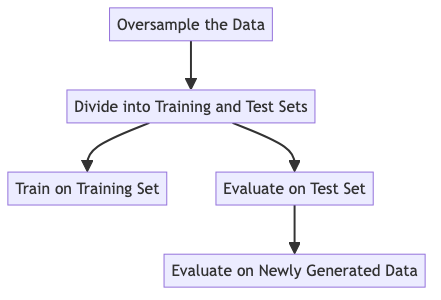

We start by creating an instance of the SMOTE oversampler and
configuring it to use 2 nearest neighbors when generating the synthetic
samples. We use the SMOTE oversampler to oversample the minority class
in the dataset, increasing the representation of the underrepresented
class to improve model performance.

In [ ]:
# Training model with data leakage

# Dictionary to store results of the model with data leakage
leak_results = {'balanced': 0.0, 'new_data': 0.0, 'correct': 0.0}

# Create an instance of the SMOTE oversampler
oversampler = smote(n_neighbors=2)

# Oversample the data using SMOTE
X_oversamp, y_oversamp, parent = oversampler.sample(X, y)

# Count the number of occurrences of each unique value in oversampled y
counts = np.unique(y_oversamp,return_counts=True)
# Print the count of the first unique value
print("Count of",counts[0][0],":",counts[1][0])
# Print the count of the second unique value
print("Count of",counts[0][1],":",counts[1][1])

After oversampling, we split the dataset into training and testing sets
using the `ShuffleSplit` from scikit-learn’s model_selection module. We
use an 80-20 train-test split, which means 80% of the data will be used
for training the model, and 20% will be held out for testing.

In [ ]:
# Define a ShuffleSplit object for splitting the data
rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=5)

# Split the oversampled data into training and testing sets
train_index, test_index = next(rs.split(X_oversamp))
X_train, y_train = X_oversamp[train_index], y_oversamp[train_index]
X_test, y_test = X_oversamp[test_index], y_oversamp[test_index]

We initialise `SVC` with rbf kernel and fit the classifier on the
training set. After training, we evaluate the classifier on the test set
and newly generated data.

In [ ]:
# Create and train an SVM classifier
svm = SVC(kernel='rbf', C=10.0, gamma=0.5, random_state=5)
svm.fit(X_train, y_train)

# Predict labels for the test set using the trained SVM
y_pred=svm.predict(X_test)

# Evaluate model performance on test set
print("\nResults on test set:\n")
leak_results["balanced"] = accuracy_score(y_test, y_pred)
print("Accuracy:",leak_results["balanced"])

# Generate new data and evaluate model performance
X_eval, y_eval = make_classification(n_samples=15, n_features=2, n_redundant=0, random_state=5, weights=[0.8,0.2])
y_eval_pred = svm.predict(X_eval)

print("\nResults on newly generated data:\n")
leak_results["new_data"] = accuracy_score(y_eval, y_eval_pred)
print("Accuracy:",leak_results["new_data"])

We display indices from X_oversamp present in the training and test
sets. Then, we identify and present the synthetic indices from
X_oversamp present in the training and test sets.

In [ ]:
print("Indices from X_oversamp in training set:",train_index)
# Identify the synthetic samples in training set
train_syn = np.where(train_index>=X.shape[0])[0]
print("Indices from X_oversamp of synthetic samples in training set:", train_index[train_syn])

print("Indices of X_oversamp present in test set:",test_index)
# Identify the synthetic samples in test set
test_syn=np.where(test_index>=X.shape[0])[0]
print("Indices of synthetic samples in test set:",test_index[test_syn])

We present the indices of the minority samples from `X_oversamp` that
were used to generate the synthetic samples present in the training set.

In [ ]:
# Identify parent samples of synthetic samples in training set
print("Indices of parent samples of synthetic samples in training set:")
print(parent[train_index][train_syn])
train_leak = np.isin(parent[train_index][train_syn],test_index)
train_leak = np.sum(np.any(train_leak,axis=1))

We present the indices of the minority samples from `X_oversamp` that
were used to generate the synthetic samples present in the test set. We
also report the number of synthetic test set samples that were derived
from minority samples in the training set.

In [ ]:
# Identify parent samples of synthetic samples in test set
print("Indices of parent samples of synthetic samples in test set:")
print(parent[test_index][test_syn])
test_leak = np.isin(parent[test_index][test_syn],train_index)
test_leak = np.sum(np.any(test_leak,axis=1))
print("Number of samples in test set derived from training set:",test_leak)

The code below creates scatter plots to visualize the following:

-   Original dataset: Green points represent majority class samples, and
    red points represent minority class samples.
-   Oversampled dataset: Green and red points represent majority and
    minority class samples, respectively. Hollow red points indicate
    synthetic minority class samples.
-   Training set: Solid green and red points represent majority and
    minority class samples, respectively. Hollow red points indicate
    synthetic minority class samples.
-   Test set: Solid green and blue points represent majority and
    minority class samples, respectively. Hollow blue points indicate
    synthetic minority class samples.

Feature 1 is plotted on x-axis and feature 2 is plotted on y-axis.

In [ ]:
# Set up the figure and grid for subplots
fig = plt.figure(figsize=(24, 14))
spec = fig.add_gridspec(2, 3)

# Create subplots
ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax20 = fig.add_subplot(spec[0, 2])
ax21 = fig.add_subplot(spec[1, 2])

# Plotting the original dataset
ax0.scatter(X[:,0], X[:,1], c=["tab:green" if i==0.0 else "tab:red" for i in y])
ax0.set_xlim(-3, 3)
ax0.set_ylim(-3.5, 3)
ax0.set_title("Original Dataset")
ax0.set_xlabel("Feature-1")
ax0.set_ylabel("Feature-2")

# Get the number of original samples
num_original = X.shape[0]

# Plotting the oversampled dataset
# Plot original samples
ax1.scatter(X_oversamp[:num_original, 0], X_oversamp[:num_original, 1], 
            c=['tab:green' if label == 0.0 else 'tab:red' for label in y_oversamp[:num_original]], 
            edgecolor='none')
# Highlight the synthetic samples
ax1.scatter(X_oversamp[num_original:, 0], X_oversamp[num_original:, 1], 
            facecolor='none', 
            edgecolor=['tab:green' if label == 0.0 else 'tab:red' for label in y_oversamp[num_original:]])
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3.5, 3)
ax1.set_title("Oversampled Dataset")
ax1.set_xlabel("Feature-1")
ax1.set_ylabel("Feature-2")

# Plotting the training data
# Plot original samples in training set
ax20.scatter(X_train[~np.isin(train_index, train_index[train_syn]), 0], 
             X_train[~np.isin(train_index, train_index[train_syn]), 1], 
             c=['tab:green' if label == 0.0 else 'tab:red' for label in y_train[~np.isin(train_index, train_index[train_syn])]], 
             edgecolor='none')
# Plot synthetic samples in training set
ax20.scatter(X_oversamp[train_index[train_syn], 0], X_oversamp[train_index[train_syn], 1], 
             facecolor='none', 
             edgecolor=['tab:green' if label == 0.0 else 'tab:red' for label in y_oversamp[train_index[train_syn]]])
ax20.set_xlim(-3, 3)
ax20.set_ylim(-3.5, 3)
ax20.set_title("Training Set")
ax20.set_xlabel("Feature-1")
ax20.set_ylabel("Feature-2")

# Plotting the test set
# Plot original samples in test set
ax21.scatter(X_test[~np.isin(test_index, test_index[test_syn]), 0], 
             X_test[~np.isin(test_index, test_index[test_syn]), 1], 
             c=['tab:green' if label == 0.0 else 'tab:red' for label in y_test[~np.isin(test_index, test_index[test_syn])]], 
             edgecolor='none')
# Plot synthetic samples in test set
ax21.scatter(X_oversamp[test_index[test_syn], 0], X_oversamp[test_index[test_syn], 1], 
             facecolor='none', 
             edgecolor=['tab:green' if label == 0.0 else 'tab:red' for label in y_oversamp[test_index[test_syn]]])
ax21.set_xlim(-3, 2)
ax21.set_ylim(-3.5, 3)
ax21.set_title("Test Set")
ax21.set_xlabel("Feature-1")
ax21.set_ylabel("Feature-2")

# Display the plot
plt.show()

This code creates scatter plots to visualize:

-   Training set:
    -   Solid green points for majority class samples.
    -   Solid red points for original minority class samples.
    -   Hollow red points for synthetic minority class samples.
-   Test set:
    -   Solid green points for majority class samples.
    -   Solid blue points for original minority class samples.
    -   Hollow blue points for synthetic minority class samples.

Arrows are drawn from each synthetic training sample to its two parent
samples.

-   Data leakage: Arrows point to at least one blue point, indicating a
    test set minority sample as a parent.
-   No data leakage: Both arrows point to red points, indicating both
    parents are from the training set.

The x-axis represents feature 1, and the y-axis represents feature 2.

In [ ]:
# Define a function to plot both training and test sets
def plot_data(ax):
    # Plot original training samples
    ax.scatter(X_train[~np.isin(train_index, train_index[train_syn]), 0], 
               X_train[~np.isin(train_index, train_index[train_syn]), 1], 
               c=['tab:green' if label == 0.0 else 'tab:red' for label in y_train[~np.isin(train_index, train_index[train_syn])]], 
               edgecolor='none')
    # Plot synthetic training samples with hollow markers
    ax.scatter(X_oversamp[train_index[train_syn], 0], 
               X_oversamp[train_index[train_syn], 1], 
               facecolor='none', 
               edgecolor=['tab:green' if label == 0.0 else 'tab:red' for label in y_oversamp[train_index[train_syn]]])
    # Plot original test samples
    ax.scatter(X_test[~np.isin(test_index, test_index[test_syn]), 0], 
               X_test[~np.isin(test_index, test_index[test_syn]), 1], 
               c=['tab:green' if label == 0.0 else 'tab:blue' for label in y_test[~np.isin(test_index, test_index[test_syn])]], 
               edgecolor='none')
    # Plot synthetic test samples with hollow markers
    ax.scatter(X_oversamp[test_index[test_syn], 0], 
               X_oversamp[test_index[test_syn], 1], 
               facecolor='none', 
               edgecolor=['tab:green' if label == 0.0 else 'tab:blue' for label in y_oversamp[test_index[test_syn]]])
    ax.set_ylim(-3, 2)
    ax.set_xlim(-0.5, 3)
    ax.set_title("Training & Test Data")
    ax.set_xlabel("Feature-1")
    ax.set_ylabel("Feature-2")

# Create a new figure with subplots
fig, axes = plt.subplots((len(train_syn)//2)+len(train_syn)%2, 2, figsize=(14,6*len(train_syn)//2))
axes = axes.flatten()

# Plot data and arrows for each synthetic sample
for idx, i in enumerate(train_syn):
    ax = axes[idx]
    plot_data(ax)

    p = parent[train_index[i]]

    # Draw an arrow from the synthetic sample to its first parent
    arrow1 = FancyArrowPatch((X_oversamp[train_index[i],0], X_oversamp[train_index[i],1]),
                             (X_oversamp[p[0],0], X_oversamp[p[0],1]),
                             arrowstyle='->', mutation_scale=20)
    ax.add_patch(arrow1)

    # Draw an arrow from the synthetic sample to its second parent
    arrow2 = FancyArrowPatch((X_oversamp[train_index[i],0], X_oversamp[train_index[i],1]),
                             (X_oversamp[p[1],0], X_oversamp[p[1],1]),
                             arrowstyle='->', mutation_scale=20)
    ax.add_patch(arrow2)

plt.show()

In this code cell, we present the data leakage statistics and calculate
the percentage of training set samples derived from test set samples.

In [ ]:
# Print results of data leakage analysis
print("Number of samples in train set:",y_train.shape[0])
print("Number of samples in test set:",y_test.shape[0])
print("Number of synthetic samples in train set:",train_syn.shape[0])
print("Number of synthetic samples in test set:",test_syn.shape[0])
print("Number of samples in train set derived from test set:", train_leak)
print("Percentage of train set derived from test set:",round(train_leak*100/train_index.shape[0],2),"%")

# Training SVM - without Data Leakage ✅

In this section, the dataset is split into training and test sets using
`ShuffleSplit`. We oversample the training set using our implementation
of SMOTE. A Support Vector Machine model is then trained on the
oversampled training set. To analyse data leakage, we calculate the
number of samples in training set derived from test set. We evaluate the
performance of the SVM model on the original (imbalanced) test set, the
oversampled test set, and newly generated data. We report the accuracy
achieved in each case.

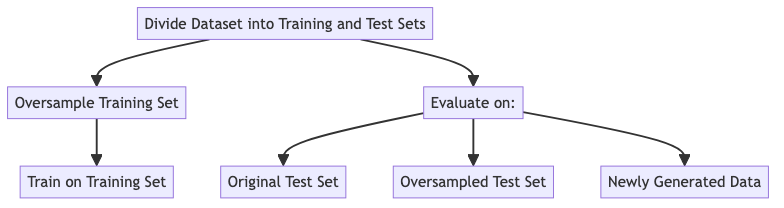

In [ ]:
# Create an instance of the SMOTE oversampler
oversampler = smote(n_neighbors=2)

# Dictionary to store results of the model without data leakage
cor_results={'balanced': 0.0, 'new_data': 0.0, 'correct': 0.0}

# Define a ShuffleSplit object for splitting the data
rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=30)

# Split the original data into training and testing sets
train_index_cor, test_index_cor = next(rs.split(X))
X_train_cor, y_train_cor = X[train_index_cor], y[train_index_cor]
X_test_cor, y_test_cor = X[test_index_cor], y[test_index_cor]

# Oversample the training set using SMOTE
X_train_oversamp, y_train_oversamp, parent_train = oversampler.sample(X_train_cor, y_train_cor)

# Create and train an SVM classifier
svm_cor = SVC(kernel='rbf', C=10.0, gamma=1.0, random_state=5)
svm_cor.fit(X_train_oversamp, y_train_oversamp)

print("\nResults on balanced test set:\n")

# Oversample the test set using SMOTE
X_test_oversamp, y_test_oversamp, parent_test = oversampler.sample(X_test_cor, y_test_cor)

# Make predictions on the oversampled test set
y_pred_oversamp = svm_cor.predict(X_test_oversamp)

# Evaluate model performance on oversampled test set
cor_results["balanced"] = accuracy_score(y_test_oversamp, y_pred_oversamp)
print("Accuracy:", cor_results["balanced"])

print("\nResults on original test set:\n")

# Predict labels for the original test set using the trained SVM
y_pred = svm_cor.predict(X_test_cor)

# Evaluate model performance on original test set
cor_results["correct"] = accuracy_score(y_test_cor, y_pred)
print("Accuracy:", cor_results["correct"])

print("\nResults on newly generated data:\n")

# Generate a new dataset for evaluation
X_cor_eval, y_cor_eval = make_classification(n_samples=15, n_features=2, n_redundant=0, random_state=5, weights=[0.8,0.2])

# Make predictions on the new dataset
y_cor_eval_pred = svm_cor.predict(X_cor_eval)

# Evaluate model performance on new dataset
cor_results["new_data"] = accuracy_score(y_cor_eval, y_cor_eval_pred)
print("Accuracy:", cor_results["new_data"])


In this code cell, we create a dataframe using the feature matrix X with
columns feature-1 and feature-2. Then, we add another column for the
target variable. The dataframe is saved as CSV file.

In [ ]:
# Create a DataFrame from the feature data X
df = pd.DataFrame(X, columns=['feature-1', 'feature-2'])

# Add the label data y as a new column in the DataFrame
df['label'] = y

# Save the DataFrame to a CSV file named "toy_data.csv" in the parent directory
# The index=False parameter ensures that the DataFrame's index is not written to the CSV file
df.to_csv("../toy_data.csv", index=False)

We create a barplot to visualise and compare the results obtained with
both models on test sets and new data.

In [ ]:
# Define X-axis values for three groups of bars
coordinates = np.arange(3)

# Set the width of each bar
width = 0.25

# Plot the bars for the data leakage results
# Shift these bars slightly to the left (-width/2)
plt.bar(coordinates - width/2, leak_results.values(), width, label='Data Leakage')

# Plot the bars for the correct results
# Shift these bars slightly to the right (+width/2)
plt.bar(coordinates + width/2, cor_results.values(), width, label='Without Data Leakage')

# Set the X-axis tick locations to be centered between each pair of bars
# Use the keys from cor_results as labels for these ticks
plt.xticks(coordinates, cor_results.keys())

# Set the Y-axis to range from 0 to 1
plt.ylim(0.0, 1.0)

# Add a legend
plt.legend()
# Display the plot
plt.show()

# Discussion

The model with data leakage achieved higher accuracy on the test set
than the model without data leakage, confirming that data leakage leads
to overly optimistic evaluation of model performance. We have
oversampled the test set in the second case to provide fair comparison
between the models. However, oversampling the test set is not
recommended as the test set should represent the distribution of
real-world data. We have also reported the metrics obtained with the
original test set to provide correct evaluation of the model’s
performance.

| Metric | With Data Leakage | Without Data Leakage (oversampled test set) | Without Data Leakage (original test set) |
|:--------:|:----------:|:------------------------:|:-----------------------:|
| Accuracy | 92.86 | 54.17 | 77.78 |

To demonstrate the impact of data leakage on performance of model in
real life, we generated new data to test both models. From the results,
we can infer that the model with data leakage fails to generalise on
unseen data, whereas the model without data leakage performs better on
unseen data. This confirms that data leakage leads to a decline in model
generalizability.

|  Metric  | With Data Leakage (New Data) | Without Data Leakage (New Data) |
|:--------:|:----------------------------:|:-------------------------------:|
| Accuracy |            73.33             |              80.0               |

Things to remember:

-   Split dataset before doing any preprocessing
-   Train on training set
-   Subject your test set to the same preprocessing steps but do not
    change distribution of test set
-   Test on test set to ensure reliability and integrity of your
    findings